# Vesuvius Challenge Inference baseline

This notebook is an example on how to use pretrained models and submit the results

## Imports

In [1]:
import sys
sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')
sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')

In [2]:
import json
import logging
import os
from collections import defaultdict
from dataclasses import dataclass
from io import StringIO
from pathlib import Path
from typing import Union, get_type_hints

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from dotenv import load_dotenv
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
import segmentation_models_pytorch as smp


## Initial structures

In [3]:
%%writefile .env

LOG_LEVEL = INFO
ENVIRONMENT = kaggle
TILE_SIZE = 224
Z_START = 29
Z_NUMBER = 6

BATCH_SIZE = 4

Writing .env


In [4]:
load_dotenv()


TRAINING_KEYS = ["BATCH_SIZE", "EPOCHS", "LEARNING_RATE", "PATIENCE", "CV_FOLDS", "FOLD_IDX", "TILE_SIZE"]

dataset_path_map = {
    "local": "dataset",
    "kaggle": "/kaggle/input/vesuvius-challenge-ink-detection",
}


class AppConfigError(Exception):
    """Raised when there is an error in the configuration"""


class AppConfig:
    """
    General configuration class for the project
    Maps environment variables to class attributes
    """

    SEED: int = 777
    LOG_LEVEL: str
    ENVIRONMENT: str
    TILE_SIZE: int
    BATCH_SIZE: int
    EPOCHS: int = 200
    MODEL: str = ""
    LEARNING_RATE: float = 1e-3
    CHECKPOINTS_DIR: Path = '.'
    PATIENCE: int = 10
    CV_FOLDS: int = 5
    FOLD_IDX: int = -1
    WANDB_API_KEY: str = ""
    Z_START: int = 0
    Z_NUMBER: int = 65

    def __init__(self, env):
        for field in self.__annotations__:  # pylint: disable=no-member
            # Raise AppConfigError if required field not supplied
            default_value = getattr(self, field, None)
            if default_value is None and env.get(field) is None:
                raise AppConfigError(f"The {field} field is required")

            # Cast env var value to expected type and raise AppConfigError on failure
            try:
                var_type = get_type_hints(AppConfig)[field]
                if var_type == bool:
                    value = _parse_bool(env.get(field, default_value))
                else:
                    value = var_type(env.get(field, default_value))

                self.__setattr__(field, value)
            except ValueError as err:
                raise AppConfigError(
                    f'Unable to cast value of "{env[field]}" to type "{var_type}" for "{field}" field'
                ) from err

    @property
    def NUM_WORKERS(self) -> int:
        """Defines the number of workers for the DataLoader"""
        return os.cpu_count() or 0

    @property
    def DEVICE(self) -> torch.device:
        """Defines the device to use for training"""
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

    @property
    def DATASET_PATH(self) -> Path:
        """Defines the path to the dataset logic"""
        return Path(dataset_path_map[self.ENVIRONMENT])

    @property
    def WANDB_PROJECT(self) -> str:
        return "Vesuvius Challenge"

    def __repr__(self):
        attrs = {
            **vars(self),
            **{
                prop_name: str(getattr(self, prop_name))
                for prop_name in dir(self)
                if isinstance(getattr(type(self), prop_name, None), property)
            },
        }

        # Remove private attributes
        attrs.pop("WANDB_API_KEY", None)

        attrs_str = json.dumps(attrs, indent=4, sort_keys=True, cls=ConfigEncoder)
        return f"{type(self).__name__}({attrs_str})"

    def __getitem__(self, key):
        return self.__getattribute__(key)

Config = AppConfig(os.environ)

In [5]:
logger = logging.getLogger(__name__)
logger.setLevel(Config.LOG_LEVEL)
stream_handler = logging.StreamHandler()
stream_handler.setStream(tqdm)
logger.addHandler(stream_handler)

## DataSet

In [6]:
class VesuviusOriginalDataSetTest(Dataset):
    """This dataset uses original data from Vesuvius Challenge.
    No optimizations, processing, and separations applied.
    """

    def __init__(self, fragment_path, tile_size=None, z_start=None, z_number=None):
        self.voxels_data = None
        self.masked_idxs = None
        self.tile_size = tile_size or Config.TILE_SIZE
        self.z_start = z_start or Config.Z_START
        self.z_number = z_number or Config.Z_NUMBER
        self._load_data(fragment_path)

    def _load_data(self, fragment_path):
        logger.info("Loading the data...")
        
        self.voxels_data, masked_idxs = self._load_fragment(fragment_path)
        self.masked_idxs = np.array(masked_idxs, dtype=np.int16)
        

    def _load_fragment(self, fragment_path: Path):
        slice_paths = sorted(list((fragment_path / "surface_volume").glob("*.tif")))
        slice_paths = filter(self.is_slice_to_load, slice_paths)
        mask = cv2.imread(str(fragment_path / "mask.png"), cv2.IMREAD_GRAYSCALE).astype(bool)
        masked_idxs = self._get_masked_idxs(mask)
        voxels_data = np.empty((len(masked_idxs), self.z_number, self.tile_size, self.tile_size), dtype=np.uint8)
        for i, slice_path in enumerate(tqdm(slice_paths, leave=False)):
            # In this case, we use cv2 to load image, because it's faster than PIL
            slice_img = cv2.imread(str(slice_path), cv2.IMREAD_UNCHANGED)

            # Convert to uint8 to save memory usage
            slice_data = (slice_img // 255).astype(np.uint8)

            voxels_data[:, i, :, :] = self._split_slice(slice_data, masked_idxs)

        return voxels_data, masked_idxs

    def is_slice_to_load(self, slice_path: Path) -> bool:
        try:
            return self.z_start <= int(slice_path.stem) < self.z_start + self.z_number
        except ValueError:
            return False

    def _get_masked_idxs(self, mask):
        """
        Returns list of tuples with indexes of tiles with data.
        Basically, the idea of this function is to pre calculate the indexes of tiles with data,
        so it would be possible to pre-allocate memory for the fragments and then just fill it with data.
        This approach is much faster and less memory consuming than just appending to the list and concatenating then.
        """
        mask_idxs = []
        for i in range(0, mask.shape[0], self.tile_size):
            for j in range(0, mask.shape[1], self.tile_size):
                if mask[i : i + self.tile_size, j : j + self.tile_size].any():
                    mask_idxs.append((i, j))
        return mask_idxs

    def _split_slice(self, slice_data, masked_idxs):
        """Split slice into tiles. It's possible to mask to filter out tiles with no data."""
        tiles = np.empty((len(masked_idxs), self.tile_size, self.tile_size), dtype=np.uint8)
        for k, (i, j) in enumerate(masked_idxs):
            tile = slice_data[i : i + self.tile_size, j : j + self.tile_size]
            if tile.shape != (self.tile_size, self.tile_size):
                tile = np.pad(
                    tile,
                    (
                        (0, self.tile_size - tile.shape[0]),
                        (0, self.tile_size - tile.shape[1]),
                    ),
                    "constant",
                    constant_values=0,
                )

            tiles[k] = tile

        return tiles

    def __len__(self) -> int:
        return self.voxels_data.shape[0]

    def __getitem__(self, index):
        voxel = (self.voxels_data[index]).astype(np.float32) / 255.
        tile_coords = self.masked_idxs[index]
        return torch.from_numpy(voxel).unsqueeze(0), tile_coords
    
    
class UNetDataSetTest(VesuviusOriginalDataSetTest):
    def __getitem__(self, index):
        voxel = (self.voxels_data[index]).astype(np.float32) / 255.
        tile_coords = self.masked_idxs[index]
        return torch.from_numpy(voxel), tile_coords

## Models

In [7]:
class InkDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()

        filters = [16, 32, 64]
        paddings = [1, 1, 1]
        kernel_sizes = [3, 3, 3]
        strides = [2, 2, 2]

        layers = []
        in_channels = 1
        for num_filters, padding, kernel_size, stride in zip(
            filters, paddings, kernel_sizes, strides
        ):
            layers.extend(
                [
                    nn.Conv3d(
                        in_channels=in_channels,
                        out_channels=num_filters,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding,
                    ),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm3d(num_features=num_filters),
                ]
            )
            in_channels = num_filters
        layers.append(nn.AdaptiveAvgPool3d(1))
        layers.append(nn.Flatten())

        self.encoder = nn.Sequential(*layers)
        self.decoder = nn.Sequential(
            nn.Linear(in_channels, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.decoder(features)

In [8]:
# ================= Unet ========================
# Ref: https://www.kaggle.com/code/balraj98/unet-for-building-segmentation-pytorch
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_classes=None, out_classes=1, up_sample_mode='conv_transpose'):
        in_classes = in_classes or Config.Z_NUMBER
        
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(in_classes, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)

        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)

        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        x = self.sigmoid(x)
        return x


In [9]:
class ResNet34Unet(smp.Unet):
    def __init__(self,in_classes):
        super().__init__(
        encoder_name="resnet34",
        encoder_weights=None,
        in_channels=in_classes,
        classes=1,
        activation=nn.Sigmoid,
    )


class ResNet50Unet(smp.Unet):
    def __init__(self, in_classes):
        super().__init__(
        encoder_name="resnet50",
        encoder_weights=None,
        in_channels=in_classes,
        classes=1,
        activation=nn.Sigmoid,
    )

## Models loading

In [10]:
@dataclass
class PretrainedModel:
    name: str
    model_class: nn.Module
    dataset_class: Dataset
    folds_path: Path
    tile_size: int = Config.TILE_SIZE
    z_start: int = Config.Z_START
    z_number: int = Config.Z_NUMBER
        
input_base = Path('../input')
pretrained_models = [
#     PretrainedModel("InkDetector-pure", InkDetector, VesuviusOriginalDataSetTest, input_base / 'inknetv1'),
#     PretrainedModel('Unet-224-lr4-wd7-aug3', UNet, UNetDataSetTest, input_base / 'unet-fold-1-unet-224-lr4-wd7-aug3', 224),
#     PretrainedModel('Unet-224-lr4-wd7-aug3-20-20', UNet, UNetDataSetTest, input_base / 'unet-224-lr4-wd7-20-20', 224, 20, 20),
#     PretrainedModel('Unet-224-lr4-wd7-aug3-dicebce', UNet, UNetDataSetTest, input_base / 'unet-224-lr4-wd7-aug3-29-6-dicebce', 224),
#     PretrainedModel('Unet-224-lr4-wd7-aug3-dropout25-adamw', UNet, UNetDataSetTest, input_base / 'unet-224-lr4-wd6-aug3-29-6-bce-dropout25-adamw', 224),
    PretrainedModel('ResNet50unet-lr4-wd5-29-6-dicebce', ResNet50Unet, UNetDataSetTest, input_base / 'resnet50unet-lr4-wd5-29-6-dicebce', 224,),
    PretrainedModel('ResNet50unet-lr4-wd5-20-20', ResNet50Unet, UNetDataSetTest, input_base / 'resnet50unet-lr4-wd5-20-20', 224, 20, 20),
]

## Prediction

In [11]:
def dice_coef(preds, targets, beta=0.5, smooth=1e-5):
    preds = preds.astype(float)
    targets = targets.astype(float)
    
    y_true_count = targets.sum()
    ctp = preds[targets == 1].sum()
    cfp = preds[targets == 0].sum()
    beta_squared = beta * beta
    
    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)
    return dice

Loading the data...



0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Loading the data...



0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

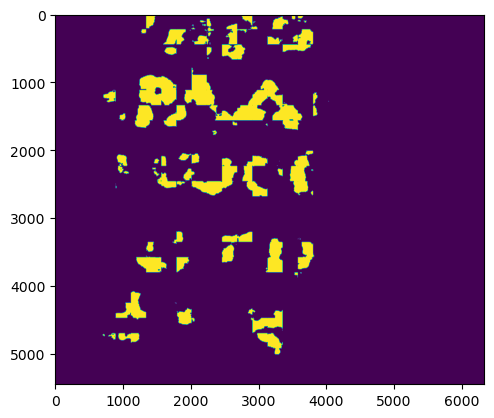

Loading the data...



0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Loading the data...



0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

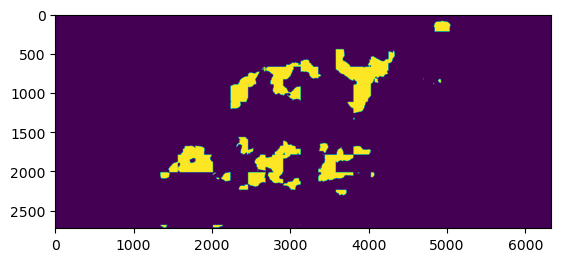

In [12]:
result = {}
for fragment_path in (Config.DATASET_PATH / 'test').iterdir():
    image_size = cv2.imread(str(fragment_path / 'mask.png')).shape[:2]
    
    ink_masks = []
    for pretrained_model in pretrained_models:
        dataset = pretrained_model.dataset_class(
            fragment_path, 
            pretrained_model.tile_size, 
            pretrained_model.z_start, 
            pretrained_model.z_number
        )
        dataloader = DataLoader(
            dataset, 
            batch_size=Config.BATCH_SIZE,
            num_workers=Config.NUM_WORKERS
        )
        
        model = pretrained_model.model_class(in_classes=pretrained_model.z_number).to(Config.DEVICE)
        for fold_path in tqdm(list(pretrained_model.folds_path.iterdir())):
            ink_mask = np.zeros(image_size, dtype=bool)
            
            model.load_state_dict(torch.load(fold_path, map_location=Config.DEVICE))
            model.eval()
    
            for x, tile_coords in tqdm(dataloader, leave=False):
                x = x.to(Config.DEVICE)
                batch_pred = model(x).detach().cpu().numpy()[:, 0] > 0.5 # Prediction mask threshold

                for coords, pred in zip(tile_coords, batch_pred):
                    shape_of_mask = ink_mask[coords[0]:coords[0] + pretrained_model.tile_size, coords[1]: coords[1] + pretrained_model.tile_size].shape
                    ink_mask[coords[0]:coords[0] + pretrained_model.tile_size, coords[1]: coords[1] + pretrained_model.tile_size] = pred[:shape_of_mask[0], :shape_of_mask[1]]
            
            ink_masks.append(ink_mask)

    result_mask = np.mean(ink_masks, axis=0) > 0.5  # Majority voting strategy
    result[fragment_path.stem] = result_mask
    plt.imshow(result_mask)
    plt.show()

## Submission

In [13]:
def combined_rle(img, img_id):
    pixels = img.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    f = StringIO()
    np.savetxt(f, runs.reshape(1, -1), delimiter=" ", fmt="%d")
    predicted = f.getvalue().strip()
    return {"Id": img_id, "Predicted": predicted}

In [14]:
submission = []
for name, pred_mask in result.items():
    submission.append(combined_rle(pred_mask, name))

submission_df = pd.DataFrame(submission)
submission_df    

,Id,Predicted
0,b,1293 10 1346 142 2757 152 3588 72 7616 26 7675...
1,a,555642 3 561970 7 568299 12 574629 20 574661 2...


In [15]:
submission_df.to_csv("/kaggle/working/submission.csv", index=False)